In [1]:
import numpy as np
import pandas as pd
import pybamm
import matplotlib.pyplot as plt
from pandas import DataFrame
from utils.generate_new_volume import generate_new_volume, generate_new_volume_anisotropic
from utils.physical_properties import *
from utils.plotting import plot_volume
from skimage.transform import rescale, downscale_local_mean
import seaborn as sns
import taufactor as tau

# 4 phase volumes
# phases = ['Pore','Crack','Particle','CBD']

# Volume generation
def gen_vol_anisotropic(reduction, subregion_id, subregion, output_sz=512, is_scale_for_reduction=True):
    model_name = 'slicegan_r{}_s{}{}'.format(str(reduction).replace('.', 'p'), str(subregion_id), str(subregion))
    model_path = 'model/{}/{}'.format(model_name, model_name)

    # Need to modify output size so the size of the generated volume is the same regardless of training image resolution
    # lz size table for reference:
    # lz =  4 -> output dim = 64
    # lz =  6 -> output dim = 128
    # lz =  8 -> output dim = 192
    # lz = 10 -> output dim = 256
    # lz = 12 -> output dim = 320
    # lz = 18 -> output dim = 512
    # lz = 24 -> output dim = 704
    # lz = 32 -> output dim = 960
    # lz = 40 -> output dim = 1216
    # lz = 50 -> output dim = 1536
    # lz = 60 -> output dim = 1856
    # lz = 70 -> output dim = 2176
    # lz = 80 -> output dim = 2496
    # lz = 100 -> output dim = 3136
    
    # BIGGEST MY LAPTOP CAN HANDLE IS 512 OUTPUT DIM FOR 20% REDUCTION
    # Makes ~8x1x1 aspect ratio volume, enforces even latent vector dims (they have to be even)
    # as well as minimum size of 4. If output_sz is too small, it won't be 8x1x1.
    if is_scale_for_reduction:
        lz_0 = (np.ceil((((output_sz * reduction / (12.5 * 4)) / 0.2)+64)/(32*2))*2).astype(int)
        lz_1 = (np.ceil((((output_sz * reduction / 12.5) / 0.2)+64)/(32*2))*2).astype(int)
        lz_2 = (np.ceil((((output_sz * reduction) / 0.2)+64)/(32*2))*2).astype(int)
    else:
        lz_0 = (np.ceil(((output_sz / (12.5 * 4)) + 64)/(32*2))*2).astype(int)
        lz_1 = (np.ceil(((output_sz / 12.5) + 64)/(32*2))*2).astype(int)
        lz_2 = (np.ceil((output_sz + 64)/(32*2))*2).astype(int)

    vol = generate_new_volume_anisotropic(model_path=model_path, lz_0=lz_0, lz_1=lz_1, lz_2=lz_2)
    # downscale higher resolution images to avoid taking a really long time, rounding to preseve segmented
    # vol_reduced = np.round(downscale_local_mean(vol, int(reduction/0.2))).astype(int)
    return vol

def split_into_n_volumes(vol, num_parts, is_plot=False):
    side_len = max(vol.shape)
    long_side = np.argmax(vol.shape)
    idx_splits = np.round((np.arange(num_parts) + 1) * side_len / num_parts).astype(int)

    if is_plot:
        fig, ax = plt.subplots(1, num_parts, figsize=(20, 6))

    for i, idx in enumerate(idx_splits):
        if i == 0:
            if long_side == 0:
                vol_ = vol[0:idx, :, :]
            elif long_side == 1:
                vol_ = vol[:, 0:idx, :]
            else:
                vol_ = vol[:, :, 0:idx]
            vol_splits = [vol_]
        else:
            if long_side == 0:
                vol_ = vol[idx_splits[i-1]:idx, :, :]
            elif long_side == 1:
                vol_ = vol[:, idx_splits[i-1]:idx, :]
            else:
                vol_ = vol[:, :, idx_splits[i-1]:idx]
            vol_splits += [vol_]
        if is_plot:
            ii = int(min(vol_.shape) / 2)
            ax[i].imshow(vol_[ii, :, :], cmap = 'gray')
    
    return vol_splits

def calc_properties(vol):
    # Transport direction is the second dimension. Taufactor calculates transport on first dimension
    vol = np.moveaxis(vol, [0, 1, 2], [1, 0, 2])

    vol[vol==1] = 0
    vf_particle = volume_fraction(vol, phase_class=2)
    vf_pore     = volume_fraction(vol, phase_class=0)

    # Transport of electrolyte in positive electrode pores and CBD
    # Use taufactor multi-phase transport solver. Particle phase has 0 transport, Pore phase 100% transport, CBD
    # transport coefficient to 0.28 (F. Usseglio-Viretta, JES 2022, 10.1149/1945-7111/ac7ef9)
    vol[vol==0] = 1
    vol[vol==2] = 0
    vol[vol==3] = 2
    eff_transport = {
        1: 1.0,
        2: 0.28
    }
    s = tau.MultiPhaseSolver(vol, cond=eff_transport)
    s.solve(verbose=False, conv_crit=0.02)

    # Taufactor gives us the effective transport coefficient for all conducting phases.
    # Pybamm does not allow us to set that value, but calculates it using the pore phase volume fraction
    # using the Bruggeman relationship. Calculate the Bruggeman coefficient necessary to get Pybamm to use
    # the calculated effective transport coefficient.
    D_eff = float(s.D_eff)
    b_e = np.log(D_eff)/np.log(vf_pore) 

    # PyBaMM model
    model = pybamm.lithium_ion.DFN()
    # Default parameter set
    params = pybamm.ParameterValues("Marquis2019")
    # Modify parameters
    params['Positive electrode porosity'] = vf_pore
    params['Positive electrode active material volume fraction'] = vf_particle
    params['Positive electrode Bruggeman coefficient (electrolyte)'] = b_e
    
    # Run simulations at several rates
    current = params['Current function [A]'] # nominal is 1 C
    rate = [0.2, 1, 3]
    for r in rate:
        params['Current function [A]'] = r * current
        sim = pybamm.Simulation(model,parameter_values=params)
        try:
            sim.solve([0, 7200/r],initial_soc=1)
            sol = sim.solution
            capacity = sol['Discharge capacity [A.h]'].entries
        except:
            capacity = np.NaN
            
        if r == 0.2:
            qdis_Cb5 = np.max(capacity)
        if r == 1:
            qdis_1C = np.max(capacity)
        if r == 3:
            qdis_3C = np.max(capacity)
    
    return {
        "vf_particle": [vf_particle],
        "vf_pore": [vf_pore],
        "D_eff": [D_eff],
        "b_e": [b_e],
        "qdis_Cb5": [qdis_Cb5],
        "qdis_1C": [qdis_1C],
        "qdis_3C": [qdis_3C],
    }

def rve_analysis(volume, max_parts=10):
    # Break the volume into 1:N parts, calculate coefficient of variance versus # of parts
    # Save into a data frame with mean, std, coef_var vs num_parts and fraction
    num_parts = np.arange(max_parts) + 1
    stats_keys = ['mean_', 'std_', 'coefvar_']
    for n in num_parts:
        if n == 1:
            props = calc_properties(volume.copy())
            rve_results = {
                'fraction': [1],
                'n_parts': [1],
            }
            for key in props.keys():
                for stat in stats_keys:
                    if stat == 'mean_':
                        rve_results[stat + key] = props[key]
                    else:
                        rve_results[stat + key] = [np.NaN]
        else:
            rve_results['fraction'].append(1/n)
            rve_results['n_parts'].append(n)
            vol_splits = split_into_n_volumes(volume.copy(), n)
            for i, subvolume in enumerate(vol_splits):
                if i == 0:
                    props = calc_properties(subvolume)
                else:
                    props_ = calc_properties(subvolume)
                    for key in props.keys():
                        props[key].append(props_[key][0])
            for key in props.keys():
                for stat in stats_keys:
                    if stat == 'mean_':
                        rve_results[stat + key].append(np.mean(props[key]))
                    if stat == 'std_':
                        rve_results[stat + key].append(np.std(props[key]))
                    if stat == 'coefvar_':
                        coefvar = np.std(props[key]) / np.mean(props[key])
                        rve_results[stat + key].append(coefvar)
    return pd.DataFrame(rve_results)

def gen_volumes_and_rve(reduction, subregion_id, subregion, output_sz=512, is_scale_for_reduction=True,
                        num_replicates=10, rve_max_parts=10):
    # Generate an 8x1x1 aspect ratio volume from the specified generator with the long side length set to output_sz
    # Break the volume into 1:rve_max_parts subvolumes, calculate properties on all volumes
    # Save into a data frame with mean, std, coef_var vs num_parts and fraction
    # repeat for num_replicates
    # compute time will roughly scale with [num_replicates * (rve_max_parts!)] so don't get crazy
    
    num_parts = np.arange(rve_max_parts) + 1
    for idx_replicate in range(num_replicates):
        volume = gen_vol_anisotropic(reduction, subregion_id, subregion, output_sz, is_scale_for_reduction)
        for n_part in num_parts:
            if n_part == 1:
                props_ = calc_properties(volume.copy())
                props_['idx_replicate'] = [idx_replicate]
                props_['idx_part'] = [0]
                props_['n_part'] = [n_part]
                props_['fraction_vol'] = [1/n_part]
                if idx_replicate == 0 and n_part == 1:
                    props = props_
                else:
                    for key in props.keys():
                        props[key].append(props_[key][0])
            else:
                vol_splits = split_into_n_volumes(volume.copy(), n_part)
                for idx_part, subvolume in enumerate(vol_splits):
                    props_ = calc_properties(subvolume)
                    props_['idx_replicate'] = [idx_replicate]
                    props_['idx_part'] = [idx_part]
                    props_['n_part'] = [n_part]
                    props_['fraction_vol'] = [1/n_part]
                    for key in props.keys():
                        props[key].append(props_[key][0])
                del vol_splits
    del volume
    return pd.DataFrame(props)

## Calculate properties for raw 2D image to compare

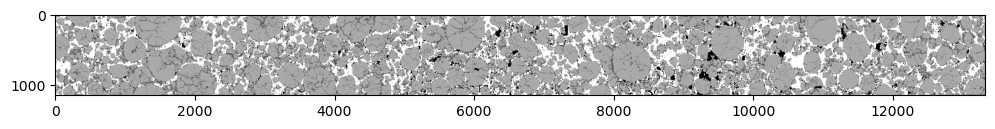

In [2]:
from skimage.io import imread, imshow
raw_2D = imread('data/nmc_1000cycles_stitched_segmented.tif')
fig, ax = plt.subplots(figsize=(12,2))
ax.imshow(raw_2D, cmap=plt.cm.gray)

In [3]:
raw_3D = np.repeat(raw_2D[:,:,np.newaxis], 1, 2)
raw_3D.shape

(1150, 13320, 1)

In [4]:
def analysis_raw_img(volume, max_parts=10):
    # Break the volume into 1:N parts, calculate coefficient of variance versus # of parts
    # Save into a data frame with mean, std, coef_var vs num_parts and fraction
    num_parts = np.arange(max_parts) + 1
    for n_part in num_parts:
        if n_part == 1:
            props_ = calc_properties_raw_img(volume.copy())
            props_['idx_part'] = [0]
            props_['n_part'] = [n_part]
            props_['fraction_vol'] = [1/n_part]
            if n_part == 1:
                props = props_
            else:
                for key in props.keys():
                    props[key].append(props_[key][0])
        else:
            vol_splits = split_into_n_volumes(volume.copy(), n_part)
            for idx_part, subvolume in enumerate(vol_splits):
                props_ = calc_properties_raw_img(subvolume)
                props_['idx_part'] = [idx_part]
                props_['n_part'] = [n_part]
                props_['fraction_vol'] = [1/n_part]
                for key in props.keys():
                    props[key].append(props_[key][0])
            del vol_splits
    return pd.DataFrame(props)

def calc_properties_raw_img(vol):
    # Set all cracks and pores equal for porosity
    vol[vol==1] = 0
    vf_particle = volume_fraction(vol, phase_class=2)
    vf_pore     = volume_fraction(vol, phase_class=0)    
    return {
        "vf_particle": [vf_particle],
        "vf_pore": [vf_pore],
    }

In [5]:
volume_properties_2D = analysis_raw_img(raw_3D, max_parts=10)
volume_properties_2D['subregion_id'] = volume_properties_2D['idx_part'] + 1
volume_properties_2D['subregion'] = volume_properties_2D['n_part']
# coefficient of variation of pore and particle volume fractions
coefvar_2D = volume_properties_2D.groupby(['n_part']).std() / volume_properties_2D.groupby(['n_part']).mean()
coefvar_2D = coefvar_2D.drop(columns=['idx_part']).reset_index()
coefvar_2D['fraction_vol'] = 1 / coefvar_2D['n_part']

### Generating volumes and calculating properties example.
- Scale of original image is 32px per micron, or, 0.03125 micron/px
- Original aspect is 12.5
- A big particle can be about 1/4th the height of the image, so minimum depth would be ~1/4th the height

| Scale | Width | Height |
|-------|-------|--------|
|100%   | 14967 |  1195  |
|80%    | 11974 |  956   |
|60%    | 8980  |  717   |
|40%    | 5987  |  478   |
|20%    | 2993  |  239   |

My laptop can get up to a generated width of 6000. 9000 explodes the computer. Ran examples at full scale on Kestrel.

In [6]:
reduction = [0.2, 0.4, 0.6, 0.8, 1.0]
subregion_id = 1
subregion = 1

is_concat = False
for red in reduction:
    properties = gen_volumes_and_rve(red, subregion_id, subregion, output_sz=2500,
                                        num_replicates=2, rve_max_parts=2, is_scale_for_reduction=False)
    properties.loc[:, 'reduction']    = red
    properties.loc[:, 'subregion_id'] = subregion_id
    properties.loc[:, 'subregion']    = subregion
    if not is_concat:
        volume_properties = properties
        is_concat = True
    else:
        volume_properties = pd.concat((volume_properties, properties))

volume_properties.reset_index(drop=True)


At t = 546.513 and h = 5.33957e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 255.604 and h = 9.44699e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 110.15 and h = 2.06315e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 495.127 and h = 7.29842e-07, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 204.653 and h = 2.19552e-07, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 62.6584 and h = 3.45454e-07, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 58.3367 and h = 6.97882e-07, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 532.752 and h = 5.63427e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 241.843 and h = 4.17366e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 96.388 and h = 5.24796e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At

,vf_particle,vf_pore,D_eff,b_e,qdis_Cb5,qdis_1C,qdis_3C,idx_replicate,idx_part,n_part,fraction_vol,reduction,subregion_id,subregion
0,0.704968,0.129226,0.035576,1.630387,1.107114,1.075974,0.584151,0,0,1,1.0,0.2,1,1
1,0.694536,0.132652,0.036693,1.636201,1.104302,1.073216,0.594730,0,0,2,0.5,0.2,1,1
2,0.715399,0.125799,0.034261,1.627414,1.109866,1.078647,0.570301,0,1,2,0.5,0.2,1,1
3,0.687576,0.133279,0.038694,1.613678,1.102367,1.071604,0.620127,1,0,1,1.0,0.2,1,1
4,0.681533,0.130220,0.039484,1.585385,1.100596,1.069967,0.624583,1,0,2,0.5,0.2,1,1
5,0.693619,0.136338,0.037709,1.645000,1.104059,1.073182,0.611908,1,1,2,0.5,0.2,1,1
0,0.659437,0.141817,0.063961,1.407666,1.092713,1.065305,0.873317,0,0,1,1.0,0.4,1,1
1,0.673110,0.145947,0.060746,1.455466,1.097994,1.069475,0.864460,0,0,2,0.5,0.4,1,1
2,0.645763,0.137687,0.066725,1.365347,1.085066,1.059660,0.876266,0,1,2,0.5,0.4,1,1
3,0.663764,0.129005,0.060762,1.367640,1.094551,1.066605,0.846474,1,0,1,1.0,0.4,1,1


<Axes: xlabel='reduction', ylabel='vf_pore'>

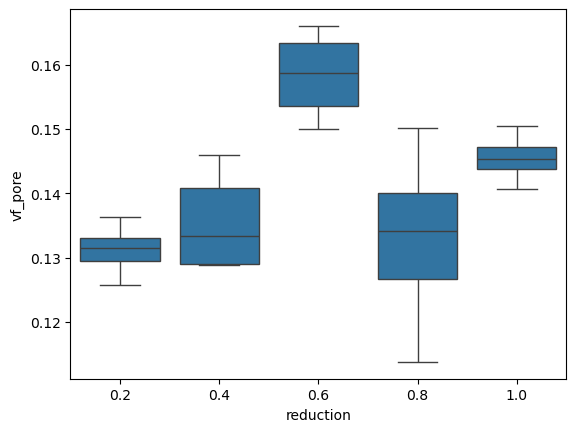

In [10]:
sns.boxplot(volume_properties, x='reduction', y='vf_pore')

<Axes: xlabel='reduction', ylabel='D_eff'>

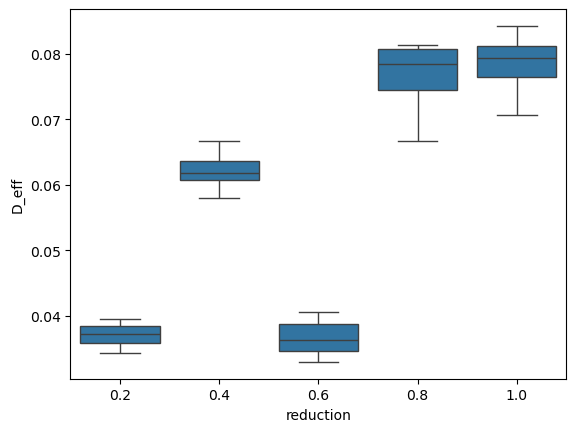

In [11]:
sns.boxplot(volume_properties, x='reduction', y='D_eff')

<Axes: xlabel='reduction', ylabel='b_e'>

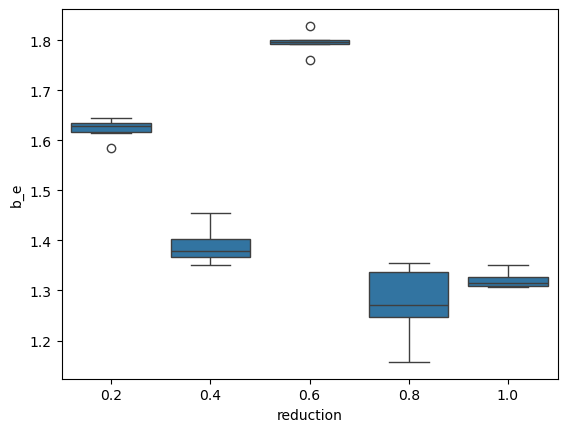

In [12]:
sns.boxplot(volume_properties, x='reduction', y='b_e')

<Axes: xlabel='reduction', ylabel='qdis_3C'>

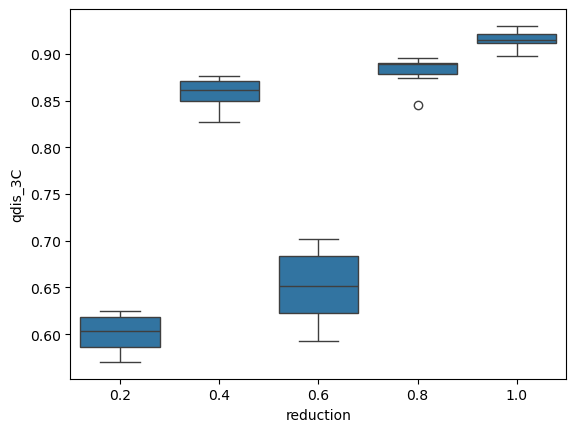

In [15]:
sns.boxplot(volume_properties, x='reduction', y='qdis_3C')

In [26]:
## RUN THIS CELL ONLY IF YOU WANT TO GENERATE VOLUMES LOCALLY. IT WILL TAKE MANY HOURS.
# lists of all the saved generators parameters, definitely not best practice to just hardcode it...
reduction =    [0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,
                0.4,0.6,0.8,1.0]
subregion_id = [1,1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,4,4,4,4,5,5,5,6,6,7,
                1,1,1,1]
subregion =    [1,2,3,4,5,6,7,2,3,4,5,6,7,3,4,5,6,7,4,5,6,7,5,6,7,6,7,7,
                1,1,1,1]

output_sz = 1856

is_concat = False
for red, sub_id, sub in zip(reduction, subregion_id, subregion):
    properties = gen_volumes_and_rve(red, sub_id, sub, output_sz=output_sz,
                                        num_replicates=5, rve_max_parts=10)
    properties.loc[:, 'reduction']    = red
    properties.loc[:, 'subregion_id'] = sub_id
    properties.loc[:, 'subregion']    = sub
    if not is_concat:
        volume_properties = properties
        is_concat = True
    else:
        volume_properties = pd.concat((volume_properties, properties))

volume_properties.reset_index(drop=True)
volume_properties.to_csv('results/volume_properties_rve.csv')

At t = 506.135 and h = 1.6772e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 215.226 and h = 9.7477e-21, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 458.685 and h = 1.57742e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 167.776 and h = 2.01091e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 510.94 and h = 8.9375e-20, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 220.031 and h = 2.16248e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 408.207 and h = 9.4691e-07, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 501.351 and h = 6.1202e-21, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 210.442 and h = 1.90689e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 456.293 and h = 6.44894e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t =

In [6]:
# local results
#### volume_properties = pd.read_csv('results/volume_properties_rve.csv')

# kestrel results
volume_properties = pd.read_csv('results/volume_properties_rve_output_sz_1856.csv')

In [7]:
volume_properties

,Unnamed: 0,vf_particle,vf_pore,D_eff,qdis_Cb5,qdis_1C,qdis_3C,idx_replicate,idx_part,n_part,fraction_vol,reduction,subregion_id,subregion,output_sz
0,0,0.713397,0.130740,0.035013,1.109347,1.078279,0.583138,0,0,1,1.000000,0.2,1,1,1856
1,1,0.721063,0.131287,0.032949,1.111340,1.079952,0.556085,0,0,2,0.500000,0.2,1,1,1856
2,2,0.705730,0.130194,0.036699,1.107331,1.076445,0.602789,0,1,2,0.500000,0.2,1,1,1856
3,3,0.724293,0.130420,0.032097,1.112175,1.080623,0.542584,0,0,3,0.333333,0.2,1,1,1856
4,4,0.709971,0.130849,0.035392,1.108444,1.077382,0.586286,0,1,3,0.333333,0.2,1,1,1856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8795,8795,0.609453,0.140005,0.085873,1.040318,1.023418,0.935548,4,5,10,0.100000,1.0,1,1,1856
8796,8796,0.603661,0.143223,0.087459,1.031162,1.014657,0.934382,4,6,10,0.100000,1.0,1,1,1856
8797,8797,0.601982,0.147294,0.090062,1.028498,1.012112,0.940916,4,7,10,0.100000,1.0,1,1,1856
8798,8798,0.610583,0.144327,0.087732,1.042097,1.025131,0.944010,4,8,10,0.100000,1.0,1,1,1856


In [8]:
mask_reduction_study = np.logical_and(volume_properties['subregion'] == 1, volume_properties['subregion_id'] == 1)
volume_properties_reduction = volume_properties.loc[mask_reduction_study].copy().reset_index()
volume_properties_0p2 = volume_properties.loc[volume_properties['reduction'] == 0.2].copy().reset_index()

In [9]:
coefvar_0p2 = volume_properties_0p2.groupby(['subregion_id','subregion','n_part']).std() / volume_properties_0p2.groupby(['subregion_id','subregion','n_part']).mean()
coefvar_0p2 = coefvar_0p2.drop(columns=['index', 'Unnamed: 0','fraction_vol','reduction','idx_part','idx_replicate']).reset_index()
coefvar_0p2['fraction_vol'] = 1 / coefvar_0p2['n_part']
coefvar_0p2

,subregion_id,subregion,n_part,vf_particle,vf_pore,D_eff,qdis_Cb5,qdis_1C,qdis_3C,output_sz,fraction_vol
0,1,1,1,0.016181,0.026364,0.048917,0.002759,0.002710,0.034556,0.0,1.000000
1,1,1,2,0.020168,0.027740,0.066980,0.003505,0.003360,0.047882,0.0,0.500000
2,1,1,3,0.021847,0.029998,0.077950,0.003812,0.003619,0.054046,0.0,0.333333
3,1,1,4,0.023289,0.047373,0.084136,0.004050,0.003870,0.060123,0.0,0.250000
4,1,1,5,0.028308,0.051808,0.099871,0.005130,0.004742,0.071131,0.0,0.200000
...,...,...,...,...,...,...,...,...,...,...,...
275,7,7,6,0.018266,0.047413,0.208330,0.003001,0.114686,0.203475,0.0,0.166667
276,7,7,7,0.017611,0.053379,0.221522,0.002911,0.123428,0.205149,0.0,0.142857
277,7,7,8,0.017485,0.056551,0.226329,0.002952,0.125975,0.212676,0.0,0.125000
278,7,7,9,0.019638,0.055922,0.234424,0.003343,0.153247,0.212101,0.0,0.111111


In [10]:
# There are some negative D_eff values. Set the D_eff and capacity to NaN for these rows.
mask_to_nan = coefvar_0p2['D_eff'] < 0
coefvar_0p2.loc[mask_to_nan, ['D_eff', 'qdis_Cb5', 'qdis_1C', 'qdis_3C']] = np.nan
mask_to_nan = volume_properties_0p2['D_eff'] < 0
volume_properties_0p2.loc[mask_to_nan, ['D_eff', 'qdis_Cb5', 'qdis_1C', 'qdis_3C']] = np.nan


In [11]:
sns.plotting_context('paper')
colors = ["#4c3e76", "#68affc", "#1c5f1e", "#d564d8", "#9ad859", "#5e34bc", "#d6c951"]
colors_reduction = ['#4c3e76', '#f46036', '#a8c256', '#f5cc8f', '#95afba']

## Subregions study

In [12]:
horzline_values = coefvar_0p2.loc[coefvar_0p2['n_part'] == 1].groupby(['subregion']).mean().reset_index()


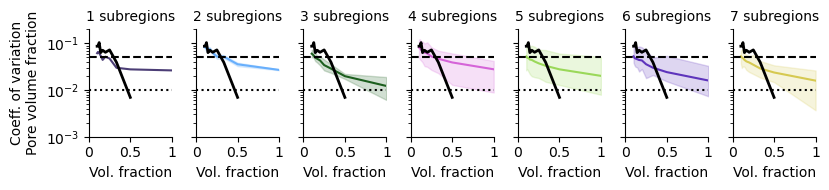

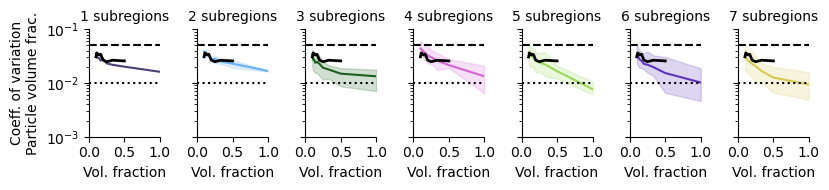

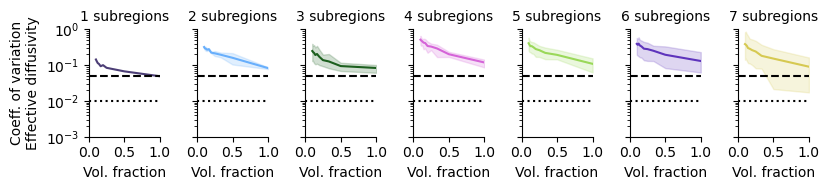

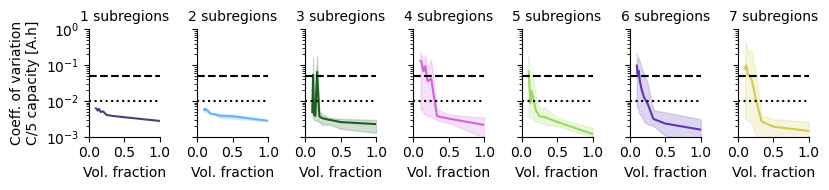

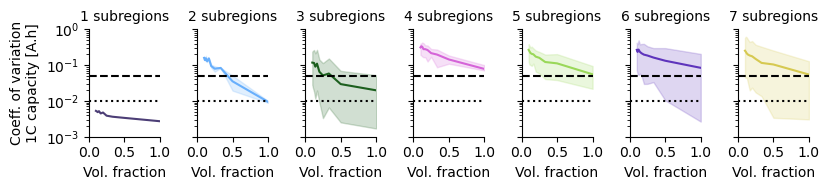

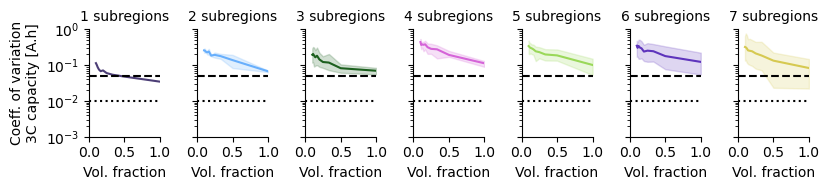

In [12]:
d = coefvar_0p2

go = sns.FacetGrid(d, col='subregion', hue='subregion',
                   palette=colors, aspect=0.6, height=2) #width=0.9, 
go.map(sns.lineplot, "fraction_vol", "vf_pore", errorbar=('pi', 100))
go.set_axis_labels("Vol. fraction", "Coeff. of variation\nPore volume fraction")
go.set_titles("{col_name} subregions")
go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0.001,0.2), yscale='log')
go.set_xticklabels(["0","0.5","1"])
go.refline(y=0.05, color='k', linestyle='--')
go.refline(y=0.01, color='k', linestyle=':')
axes = go.fig.axes
for i, ax in enumerate(axes):
    x = coefvar_2D['fraction_vol']
    y = coefvar_2D['vf_pore']
    ax.plot(x, y, '-', color='black', linewidth=2)
go.savefig('figures/subregions_rve_vpore.tif', dpi=600)

go = sns.FacetGrid(d, col='subregion', hue='subregion',
                   palette=colors, aspect=0.6, height=2) #width=0.9, 
go.map(sns.lineplot, "fraction_vol", "vf_particle", errorbar=('pi', 100))
go.set_axis_labels("Vol. fraction", "Coeff. of variation\nParticle volume frac.")
go.set_titles("{col_name} subregions")
go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0.001,0.1), yscale='log')
go.refline(y=0.05, color='k', linestyle='--')
go.refline(y=0.01, color='k', linestyle=':')
axes = go.fig.axes
for i, ax in enumerate(axes):
    x = coefvar_2D['fraction_vol']
    y = coefvar_2D['vf_particle']
    ax.plot(x, y, '-', color='black', linewidth=2)
go.savefig('figures/subregions_rve_vparticle.tif', dpi=600)

go = sns.FacetGrid(d, col='subregion', hue='subregion',
                   palette=colors, aspect=0.6, height=2) #width=0.9, 
go.map(sns.lineplot, "fraction_vol", "D_eff", errorbar=('pi', 100))
go.set_axis_labels("Vol. fraction", "Coeff. of variation\nEffective diffusivity")
go.set_titles("{col_name} subregions")
go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0.001,1), yscale='log')
go.refline(y=0.05, color='k', linestyle='--')
go.refline(y=0.01, color='k', linestyle=':')
go.savefig('figures/subregions_rve_Deff.tif', dpi=600)

go = sns.FacetGrid(d, col='subregion', hue='subregion',
                   palette=colors, aspect=0.6, height=2) #width=0.9, 
go.map(sns.lineplot, "fraction_vol", "qdis_Cb5", errorbar=('pi', 100))
go.set_axis_labels("Vol. fraction", "Coeff. of variation\nC/5 capacity [A.h]")
go.set_titles("{col_name} subregions")
go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0.001,1), yscale='log')
go.refline(y=0.05, color='k', linestyle='--')
go.refline(y=0.01, color='k', linestyle=':')
go.savefig('figures/subregions_rve_qCb5.tif', dpi=600)

go = sns.FacetGrid(d, col='subregion', hue='subregion',
                   palette=colors, aspect=0.6, height=2) #width=0.9, 
go.map(sns.lineplot, "fraction_vol", "qdis_1C", errorbar=('pi', 100))
go.set_axis_labels("Vol. fraction", "Coeff. of variation\n1C capacity [A.h]")
go.set_titles("{col_name} subregions")
go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0.001,1), yscale='log')
go.refline(y=0.05, color='k', linestyle='--')
go.refline(y=0.01, color='k', linestyle=':')
go.savefig('figures/subregions_rve_q1C.tif', dpi=600)

go = sns.FacetGrid(d, col='subregion', hue='subregion',
                   palette=colors, aspect=0.6, height=2) #width=0.9, 
go.map(sns.lineplot, "fraction_vol", "qdis_3C", errorbar=('pi', 100))
go.set_axis_labels("Vol. fraction", "Coeff. of variation\n3C capacity [A.h]")
go.set_titles("{col_name} subregions")
go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0.001,1), yscale='log')
go.refline(y=0.05, color='k', linestyle='--')
go.refline(y=0.01, color='k', linestyle=':')
go.savefig('figures/subregions_rve_q3C.tif', dpi=600)

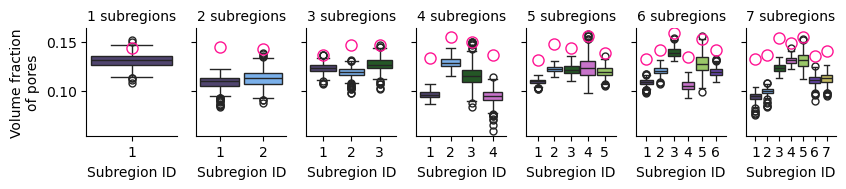

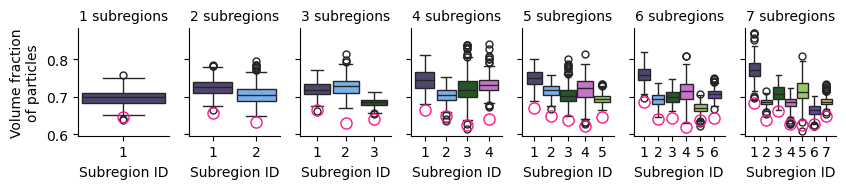

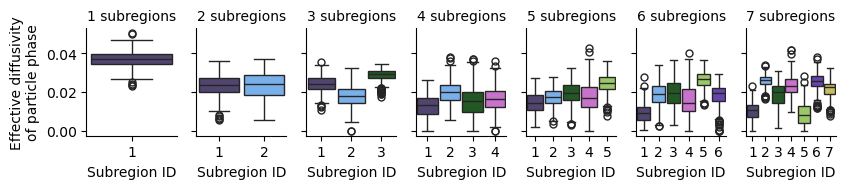

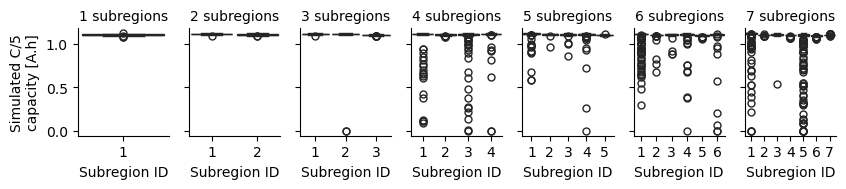

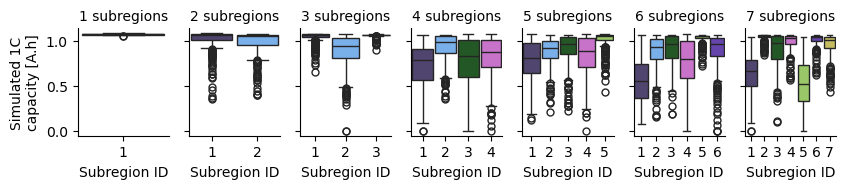

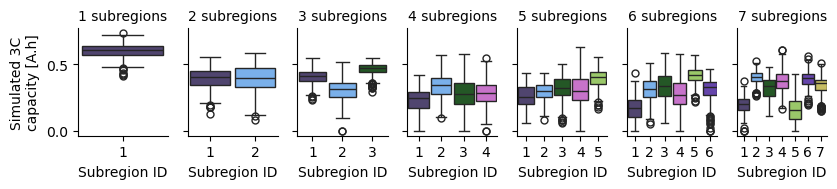

In [15]:
go = sns.catplot(data=volume_properties_0p2, y="vf_pore", x="subregion_id", hue="subregion_id", col="subregion", 
                 palette=colors, kind='box', sharex=False, width=0.9, aspect=0.6, height=2, legend=False)
go.set_axis_labels("Subregion ID", "Volume fraction\nof pores")
go.set_titles("{col_name} subregions")
axes = go.fig.axes
for i, ax in enumerate(axes):
    mask = (volume_properties_2D['n_part'] - 1) == i
    x = volume_properties_2D.loc[mask, 'idx_part']
    y = volume_properties_2D.loc[mask, 'vf_pore']
    line = ax.plot(x, y, 'o', color='deeppink', markersize=8, markerfacecolor='none')
go.savefig('figures/subregions_boxplot_vpore.tif', dpi=600)

go = sns.catplot(data=volume_properties_0p2, y="vf_particle", x="subregion_id", hue="subregion_id", col="subregion", 
                 palette=colors, kind='box', sharex=False, width=0.9, aspect=0.6, height=2, legend=False)
go.set_axis_labels("Subregion ID", "Volume fraction\nof particles")
go.set_titles("{col_name} subregions")
axes = go.fig.axes
for i, ax in enumerate(axes):
    mask = (volume_properties_2D['n_part'] - 1) == i
    x = volume_properties_2D.loc[mask, 'idx_part']
    y = volume_properties_2D.loc[mask, 'vf_particle']
    line = ax.plot(x, y, 'o', color='deeppink', markersize=8, markerfacecolor='none')
go.savefig('figures/subregions_boxplot_vparticle.tif', dpi=600)

go = sns.catplot(data=volume_properties_0p2, y="D_eff", x="subregion_id", hue="subregion_id", col="subregion", 
                 palette=colors, kind='box', sharex=False, width=0.9, aspect=0.6, height=2, legend=False)
go.set_axis_labels("Subregion ID", "Effective diffusivity\nof particle phase")
go.set_titles("{col_name} subregions")
# go.set(yscale='log')
go.savefig('figures/subregions_boxplot_Deff.tif', dpi=600)

go = sns.catplot(data=volume_properties_0p2, y="qdis_Cb5", x="subregion_id", hue="subregion_id", col="subregion", 
                 palette=colors, kind='box', sharex=False, width=0.9, aspect=0.6, height=2, legend=False)
go.set_axis_labels("Subregion ID", "Simulated C/5\ncapacity [A.h]")
go.set_titles("{col_name} subregions")
# go.set(yscale='log')
go.savefig('figures/subregions_boxplot_qCb5.tif', dpi=600)

go = sns.catplot(data=volume_properties_0p2, y="qdis_1C", x="subregion_id", hue="subregion_id", col="subregion", 
                 palette=colors, kind='box', sharex=False, width=0.9, aspect=0.6, height=2, legend=False)
go.set_axis_labels("Subregion ID", "Simulated 1C\ncapacity [A.h]")
go.set_titles("{col_name} subregions")
# go.set(yscale='log')
go.savefig('figures/subregions_boxplot_q1C.tif', dpi=600)

go = sns.catplot(data=volume_properties_0p2, y="qdis_3C", x="subregion_id", hue="subregion_id", col="subregion", 
                 palette=colors, kind='box', sharex=False, width=0.9, aspect=0.6, height=2, legend=False)
go.set_axis_labels("Subregion ID", "Simulated 3C\ncapacity [A.h]")
go.set_titles("{col_name} subregions")
# go.set(yscale='log')
go.savefig('figures/subregions_boxplot_q3C.tif', dpi=600)

In [ ]:
d = coefvar_0p2


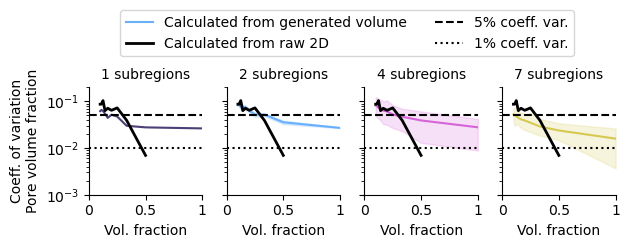

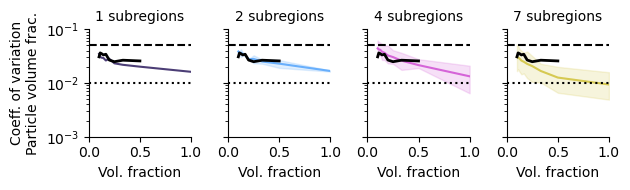

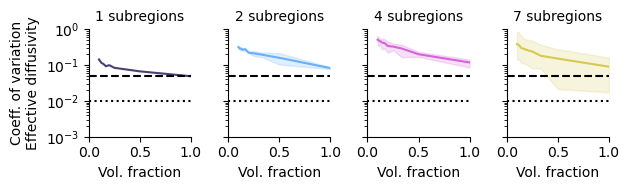

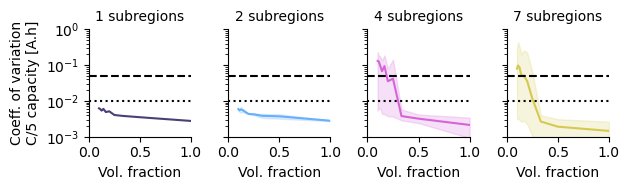

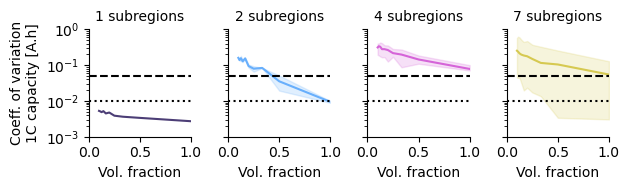

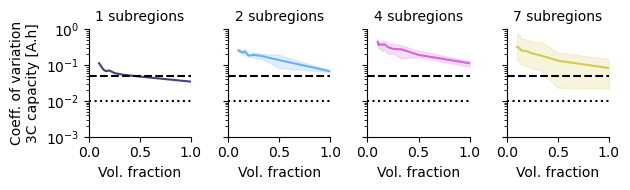

In [19]:
d = coefvar_0p2
mask_subregions = np.logical_or(d['subregion'] == 1, d['subregion'] == 2)
mask_subregions = np.logical_or(mask_subregions, d['subregion'] == 4)
mask_subregions = np.logical_or(mask_subregions, d['subregion'] == 7)
d = d.loc[mask_subregions]

go = sns.FacetGrid(d, col='subregion', hue='subregion',
                   palette=[colors[0],colors[1],colors[3],colors[6]], aspect=0.8, height=2) #width=0.9, 
go.map(sns.lineplot, "fraction_vol", "vf_pore", errorbar=('pi', 100))
go.set_axis_labels("Vol. fraction", "Coeff. of variation\nPore volume fraction")
go.set_titles("{col_name} subregions")
go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0.001,0.2), yscale='log')
go.set_xticklabels(["0","0.5","1"])
axes = go.fig.axes
for i, ax in enumerate(axes):
    x = coefvar_2D['fraction_vol']
    y = coefvar_2D['vf_pore']
    ax.plot(x, y, '-', color='black', linewidth=2)
go.refline(y=0.05, color='k', linestyle='--')
go.refline(y=0.01, color='k', linestyle=':')
axes = go.fig.axes
lines = axes[1].get_lines()
labels = ['Calculated from generated volume', 'Calculated from raw 2D', '5% coeff. var.', '1% coeff. var.']
go.figure.legend(lines, labels, ncols=2, fontsize=10, loc='center', bbox_to_anchor=(0.15, 1.05, 0.8, 0.1))
go.savefig('figures/subregions_1247_rve_vpore.tif', dpi=600)

go = sns.FacetGrid(d, col='subregion', hue='subregion',
                   palette=[colors[0],colors[1],colors[3],colors[6]], aspect=0.8, height=2) #width=0.9, 
go.map(sns.lineplot, "fraction_vol", "vf_particle", errorbar=('pi', 100))
go.set_axis_labels("Vol. fraction", "Coeff. of variation\nParticle volume frac.")
go.set_titles("{col_name} subregions")
go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0.001,0.1), yscale='log')
go.refline(y=0.05, color='k', linestyle='--')
go.refline(y=0.01, color='k', linestyle=':')
axes = go.fig.axes
for i, ax in enumerate(axes):
    x = coefvar_2D['fraction_vol']
    y = coefvar_2D['vf_particle']
    ax.plot(x, y, '-', color='black', linewidth=2)
go.savefig('figures/subregions_1247_rve_vparticle.tif', dpi=600)

go = sns.FacetGrid(d, col='subregion', hue='subregion',
                   palette=[colors[0],colors[1],colors[3],colors[6]], aspect=0.8, height=2) #width=0.9, 
go.map(sns.lineplot, "fraction_vol", "D_eff", errorbar=('pi', 100))
go.set_axis_labels("Vol. fraction", "Coeff. of variation\nEffective diffusivity")
go.set_titles("{col_name} subregions")
go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0.001,1), yscale='log')
go.refline(y=0.05, color='k', linestyle='--')
go.refline(y=0.01, color='k', linestyle=':')
go.savefig('figures/subregions_1247_rve_Deff.tif', dpi=600)

go = sns.FacetGrid(d, col='subregion', hue='subregion',
                   palette=[colors[0],colors[1],colors[3],colors[6]], aspect=0.8, height=2) #width=0.9, 
go.map(sns.lineplot, "fraction_vol", "qdis_Cb5", errorbar=('pi', 100))
go.set_axis_labels("Vol. fraction", "Coeff. of variation\nC/5 capacity [A.h]")
go.set_titles("{col_name} subregions")
go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0.001,1), yscale='log')
go.refline(y=0.05, color='k', linestyle='--')
go.refline(y=0.01, color='k', linestyle=':')
go.savefig('figures/subregions_1247_rve_qCb5.tif', dpi=600)

go = sns.FacetGrid(d, col='subregion', hue='subregion',
                   palette=[colors[0],colors[1],colors[3],colors[6]], aspect=0.8, height=2) #width=0.9, 
go.map(sns.lineplot, "fraction_vol", "qdis_1C", errorbar=('pi', 100))
go.set_axis_labels("Vol. fraction", "Coeff. of variation\n1C capacity [A.h]")
go.set_titles("{col_name} subregions")
go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0.001,1), yscale='log')
go.refline(y=0.05, color='k', linestyle='--')
go.refline(y=0.01, color='k', linestyle=':')
go.savefig('figures/subregions_1247_rve_q1C.tif', dpi=600)

go = sns.FacetGrid(d, col='subregion', hue='subregion',
                   palette=[colors[0],colors[1],colors[3],colors[6]], aspect=0.8, height=2) #width=0.9, 
go.map(sns.lineplot, "fraction_vol", "qdis_3C", errorbar=('pi', 100))
go.set_axis_labels("Vol. fraction", "Coeff. of variation\n3C capacity [A.h]")
go.set_titles("{col_name} subregions")
go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0.001,1), yscale='log')
go.refline(y=0.05, color='k', linestyle='--')
go.refline(y=0.01, color='k', linestyle=':')
go.savefig('figures/subregions_1247_rve_q3C.tif', dpi=600)

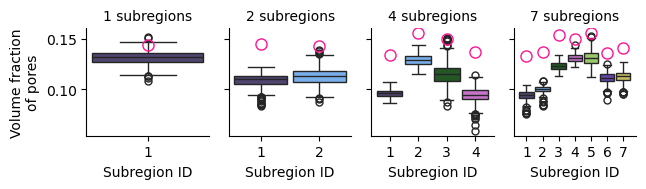

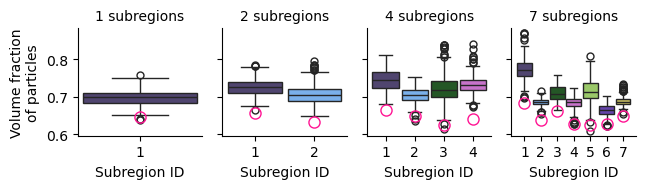

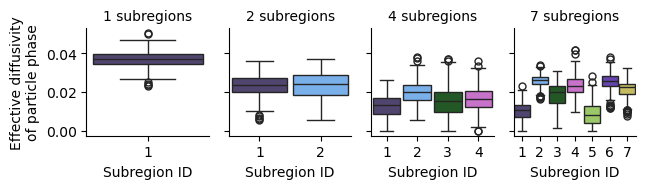

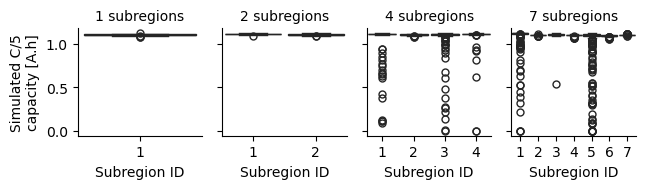

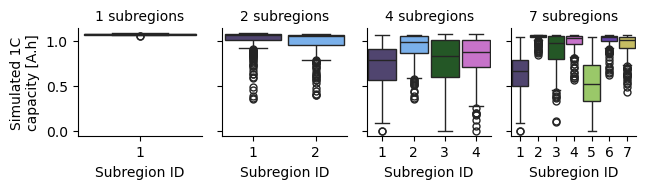

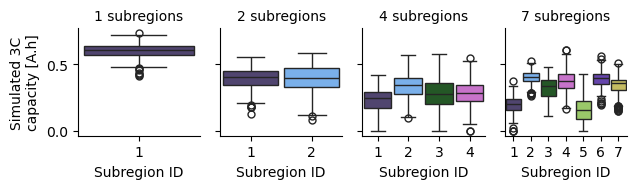

In [35]:
d = volume_properties_0p2
mask_subregions = np.logical_or(d['subregion'] == 1, d['subregion'] == 2)
mask_subregions = np.logical_or(mask_subregions, d['subregion'] == 4)
mask_subregions = np.logical_or(mask_subregions, d['subregion'] == 7)
d = d.loc[mask_subregions]

dd = volume_properties_2D
mask_subregions = np.logical_or(dd['subregion'] == 1, dd['subregion'] == 2)
mask_subregions = np.logical_or(mask_subregions, dd['subregion'] == 4)
mask_subregions = np.logical_or(mask_subregions, dd['subregion'] == 7)
dd = dd.loc[mask_subregions]

go = sns.catplot(data=d, y="vf_pore", x="subregion_id", hue="subregion_id", col="subregion", 
                 palette=colors, 
                 kind='box', sharex=False, width=0.9, aspect=0.8, height=2, legend=False)
go.set_axis_labels("Subregion ID", "Volume fraction\nof pores")
go.set_titles("{col_name} subregions")
axes = go.fig.axes
parts = [1, 2, 4, 7]
for i, ax in enumerate(axes):
    mask = dd['n_part'] == parts[i]
    x = dd.loc[mask, 'idx_part']
    y = dd.loc[mask, 'vf_pore']
    line = ax.plot(x, y, 'o', color='deeppink', markersize=8, markerfacecolor='none')
go.savefig('figures/subregions_1247_boxplot_vpore.tif', dpi=600)

go = sns.catplot(data=d, y="vf_particle", x="subregion_id", hue="subregion_id", col="subregion", 
                 palette=colors,
                 kind='box', sharex=False, width=0.9, aspect=0.8, height=2, legend=False)
go.set_axis_labels("Subregion ID", "Volume fraction\nof particles")
go.set_titles("{col_name} subregions")
axes = go.fig.axes
parts = [1, 2, 4, 7]
for i, ax in enumerate(axes):
    mask = dd['n_part'] == parts[i]
    x = dd.loc[mask, 'idx_part']
    y = dd.loc[mask, 'vf_particle']
    line = ax.plot(x, y, 'o', color='deeppink', markersize=8, markerfacecolor='none')
go.savefig('figures/subregions_1247_boxplot_vparticle.tif', dpi=600)

go = sns.catplot(data=d, y="D_eff", x="subregion_id", hue="subregion_id", col="subregion", 
                 palette=colors,
                 kind='box', sharex=False, width=0.9, aspect=0.8, height=2, legend=False)
go.set_axis_labels("Subregion ID", "Effective diffusivity\nof particle phase")
go.set_titles("{col_name} subregions")
# go.set(yscale='log')
go.savefig('figures/subregions_1247_boxplot_Deff.tif', dpi=600)

go = sns.catplot(data=d, y="qdis_Cb5", x="subregion_id", hue="subregion_id", col="subregion", 
                 palette=colors, 
                 kind='box', sharex=False, width=0.9, aspect=0.8, height=2, legend=False)
go.set_axis_labels("Subregion ID", "Simulated C/5\ncapacity [A.h]")
go.set_titles("{col_name} subregions")
# go.set(yscale='log')
go.savefig('figures/subregions_1247_boxplot_qCb5.tif', dpi=600)

go = sns.catplot(data=d, y="qdis_1C", x="subregion_id", hue="subregion_id", col="subregion", 
                 palette=colors, 
                 kind='box', sharex=False, width=0.9, aspect=0.8, height=2, legend=False)
go.set_axis_labels("Subregion ID", "Simulated 1C\ncapacity [A.h]")
go.set_titles("{col_name} subregions")
# go.set(yscale='log')
go.savefig('figures/subregions_1247_boxplot_q1C.tif', dpi=600)

go = sns.catplot(data=d, y="qdis_3C", x="subregion_id", hue="subregion_id", col="subregion", 
                 palette=colors, 
                 kind='box', sharex=False, width=0.9, aspect=0.8, height=2, legend=False)
go.set_axis_labels("Subregion ID", "Simulated 3C\ncapacity [A.h]")
go.set_titles("{col_name} subregions")
# go.set(yscale='log')
go.savefig('figures/subregions_1247_boxplot_q3C.tif', dpi=600)

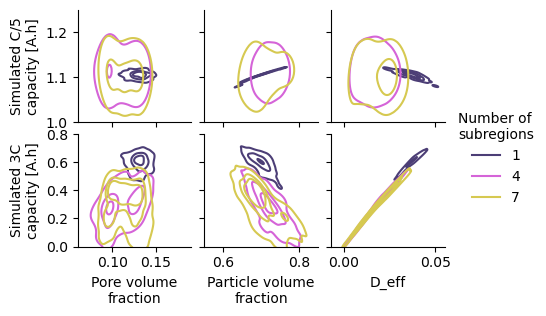

In [16]:
mask_subregions = np.logical_or(volume_properties_0p2['subregion'] == 1, volume_properties_0p2['subregion'] == 4)
mask_subregions = np.logical_or(mask_subregions, volume_properties_0p2['subregion'] == 7)
go = sns.pairplot(volume_properties_0p2.loc[mask_subregions], 
    hue='subregion', palette=[colors[0],colors[3],colors[6]], kind='kde',
    y_vars=['qdis_Cb5', 'qdis_3C'],
    x_vars=['vf_pore', 'vf_particle', 'D_eff'],
    height=1.5, plot_kws={'levels':4})
go.y_vars = ['Simulated C/5\ncapacity [A.h]', 'Simulated 3C\ncapacity [A.h]']
go.x_vars = ['Pore volume\nfraction', 'Particle volume\nfraction']
go._add_axis_labels()
go._legend.set_title('Number of\nsubregions')
go.axes[0,0].set_xlim((0.06, 0.19))
go.axes[0,1].set_xlim((0.55, 0.85))
go.axes[0,0].set_ylim((1, 1.25))
go.axes[1,0].set_ylim((0, 0.8))

go.savefig('figures/subregions_pairplot.tif', dpi=600)

## Reduction study

In [36]:
coefvar_reduction = volume_properties_reduction.groupby(['reduction','n_part']).std() / volume_properties_reduction.groupby(['reduction','n_part']).mean()
coefvar_reduction = coefvar_reduction.drop(columns=['index', 'Unnamed: 0','fraction_vol','subregion','subregion_id','idx_part','idx_replicate']).reset_index()
coefvar_reduction['fraction_vol'] = 1 / coefvar_reduction['n_part']
coefvar_reduction

,reduction,n_part,vf_particle,vf_pore,D_eff,qdis_Cb5,qdis_1C,qdis_3C,output_sz,fraction_vol
0,0.2,1,0.016181,0.026364,0.048917,0.002759,0.002710,0.034556,0.0,1.000000
1,0.2,2,0.020168,0.027740,0.066980,0.003505,0.003360,0.047882,0.0,0.500000
2,0.2,3,0.021847,0.029998,0.077950,0.003812,0.003619,0.054046,0.0,0.333333
3,0.2,4,0.023289,0.047373,0.084136,0.004050,0.003870,0.060123,0.0,0.250000
4,0.2,5,0.028308,0.051808,0.099871,0.005130,0.004742,0.071131,0.0,0.200000
5,0.2,6,0.026301,0.044353,0.093240,0.004895,0.004471,0.067654,0.0,0.166667
6,0.2,7,0.029283,0.054519,0.107796,0.005988,0.005189,0.075322,0.0,0.142857
7,0.2,8,0.029687,0.062233,0.114609,0.005364,0.004856,0.087386,0.0,0.125000
8,0.2,9,0.030534,0.065718,0.129258,0.005954,0.005118,0.102580,0.0,0.111111
9,0.2,10,0.034752,0.061722,0.143718,0.006193,0.005274,0.113539,0.0,0.100000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


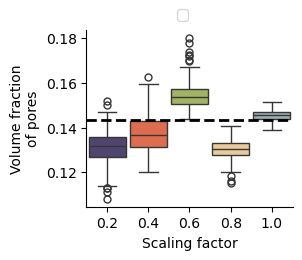

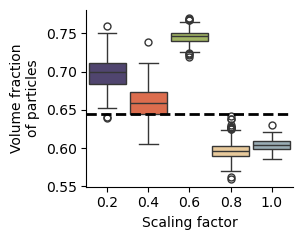

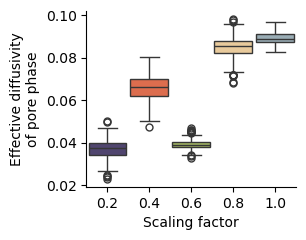

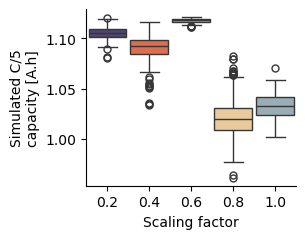

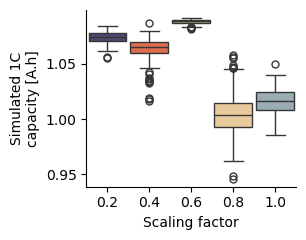

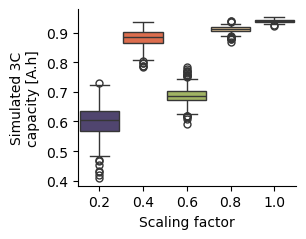

In [39]:
go = sns.catplot(data=volume_properties_reduction, y="vf_pore", x="reduction", palette=colors_reduction, hue='reduction',
                 kind='box', sharex=False, width=0.9, aspect=1.25, height=2.5, legend=False)
go.set_axis_labels("Scaling factor", "Volume fraction\nof pores")
go.refline(y=volume_properties_2D.loc[0, 'vf_pore'], color='black', linestyle='--', linewidth=2)
go.figure.legend(loc='center', bbox_to_anchor=(0.2, 0.95, 0.8, 0.1))
go.savefig('figures/reduction_boxplot_vpore.tif', dpi=600)

go = sns.catplot(data=volume_properties_reduction, y="vf_particle", x="reduction", palette=colors_reduction, hue='reduction',
                 kind='box', sharex=False, width=0.9, aspect=1.25, height=2.5, legend=False)
go.set_axis_labels("Scaling factor", "Volume fraction\nof particles")
go.refline(y=volume_properties_2D.loc[0, 'vf_particle'], color='black', linestyle='--', linewidth=2)
go.savefig('figures/reduction_boxplot_vparticle.tif', dpi=600)

go = sns.catplot(data=volume_properties_reduction, y="D_eff", x="reduction", palette=colors_reduction, hue='reduction',
                 kind='box', sharex=False, width=0.9, aspect=1.2, height=2.5, legend=False)
go.set_axis_labels("Scaling factor", "Effective diffusivity\nof pore phase")
go.savefig('figures/reduction_boxplot_Deff.tif', dpi=600)

go = sns.catplot(data=volume_properties_reduction, y="qdis_Cb5", x="reduction", palette=colors_reduction, hue='reduction',
                 kind='box', sharex=False, width=0.9, aspect=1.2, height=2.5, legend=False)
go.set_axis_labels("Scaling factor", "Simulated C/5\ncapacity [A.h]")
go.savefig('figures/reduction_boxplot_qCb5.tif', dpi=600)

go = sns.catplot(data=volume_properties_reduction, y="qdis_1C", x="reduction", palette=colors_reduction, hue='reduction',
                 kind='box', sharex=False, width=0.9, aspect=1.2, height=2.5, legend=False)
go.set_axis_labels("Scaling factor", "Simulated 1C\ncapacity [A.h]")
go.savefig('figures/reduction_boxplot_q1C.tif', dpi=600)

go = sns.catplot(data=volume_properties_reduction, y="qdis_3C", x="reduction", palette=colors_reduction, hue='reduction',
                 kind='box', sharex=False, width=0.9, aspect=1.2, height=2.5, legend=False)
go.set_axis_labels("Scaling factor", "Simulated 3C\ncapacity [A.h]")
go.savefig('figures/reduction_boxplot_q3C.tif', dpi=600)


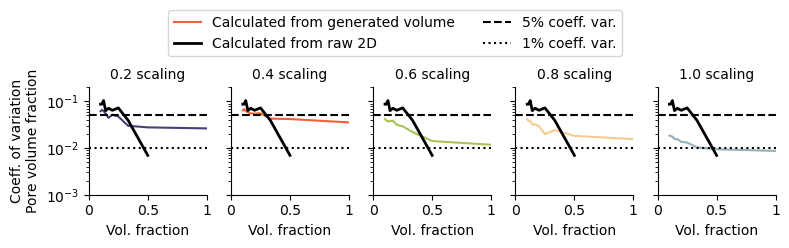

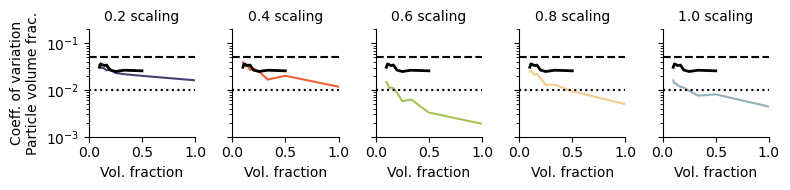

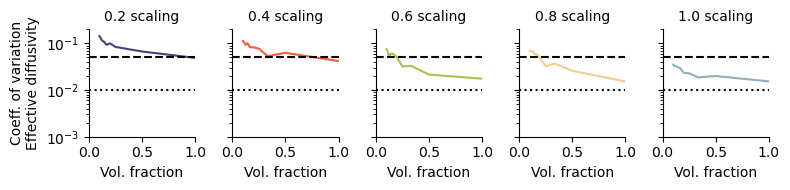

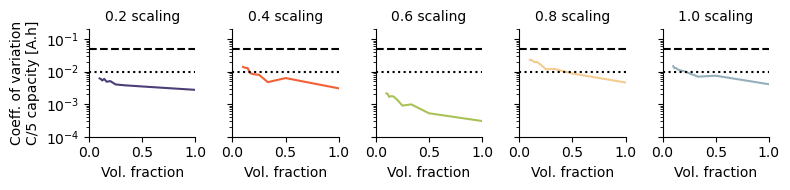

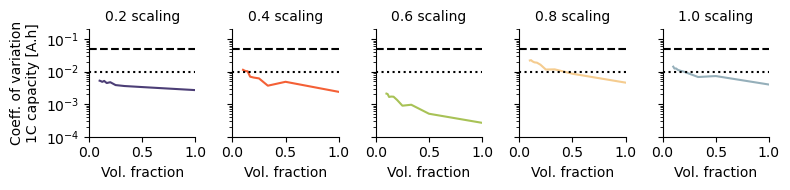

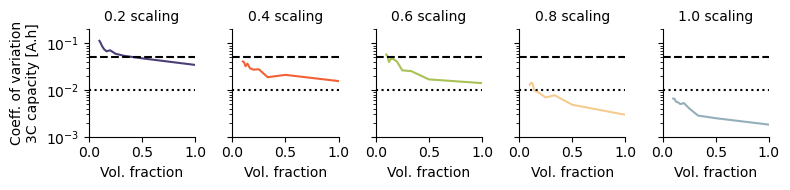

In [45]:
d = coefvar_reduction

# with sns.plotting_context("paper", font_scale=0.8):
go = sns.FacetGrid(d, col='reduction', hue='reduction',
                palette=colors_reduction, aspect=0.8, height=2) #aspect=0.8
go.map(sns.lineplot, "fraction_vol", "vf_pore", errorbar=('pi', 100))
go.set_axis_labels("Vol. fraction", "Coeff. of variation\nPore volume fraction")
go.set_titles("{col_name} scaling")
# go.refline(y=horzline_values.loc[0, 'vf_pore'], color='k', linestyle='--')
axes = go.fig.axes
for i, ax in enumerate(axes):
    x = coefvar_2D['fraction_vol']
    y = coefvar_2D['vf_pore']
    ax.plot(x, y, '-', color='black', linewidth=2)
go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0.001,0.2), yscale='log')
go.set_xticklabels(["0","0.5","1"])
go.refline(y=0.05, color='k', linestyle='--')
go.refline(y=0.01, color='k', linestyle=':')
axes = go.fig.axes
lines = axes[1].get_lines()
labels = ['Calculated from generated volume', 'Calculated from raw 2D', '5% coeff. var.', '1% coeff. var.']
go.figure.legend(lines, labels, ncols=2, fontsize=10, loc='center', bbox_to_anchor=(0.1, 1.05, 0.8, 0.1))
go.savefig('figures/reduction_rve_vpore.tif', dpi=600)

# with sns.plotting_context("paper", font_scale=0.8):
go = sns.FacetGrid(d, col='reduction', hue='reduction',
                palette=colors_reduction, aspect=0.8, height=2) #width=0.9, 
go.map(sns.lineplot, "fraction_vol", "vf_particle", errorbar=('pi', 100))
go.set_axis_labels("Vol. fraction", "Coeff. of variation\nParticle volume frac.")
go.set_titles("{col_name} scaling")
# go.refline(y=horzline_values.loc[0, 'vf_particle'], color='k', linestyle='--')
axes = go.fig.axes
for i, ax in enumerate(axes):
    x = coefvar_2D['fraction_vol']
    y = coefvar_2D['vf_particle']
    ax.plot(x, y, '-', color='black', linewidth=2)
go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0.001,0.2), yscale='log')
go.refline(y=0.05, color='k', linestyle='--')
go.refline(y=0.01, color='k', linestyle=':')
go.savefig('figures/reduction_rve_vparticle.tif', dpi=600)

go = sns.FacetGrid(d, col='reduction', hue='reduction',
                   palette=colors_reduction, aspect=0.8, height=2) #width=0.9, 
go.map(sns.lineplot, "fraction_vol", "D_eff", errorbar=('pi', 100))
go.set_axis_labels("Vol. fraction", "Coeff. of variation\nEffective diffusivity")
go.set_titles("{col_name} scaling")
go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0.001,0.2), yscale='log')
go.refline(y=0.05, color='k', linestyle='--')
go.refline(y=0.01, color='k', linestyle=':')
# go.refline(y=horzline_values.loc[0, 'D_eff'], color='k', linestyle='--')
go.savefig('figures/reduction_rve_Deff.tif', dpi=600)

# with sns.plotting_context("paper", font_scale=0.8):
go = sns.FacetGrid(d, col='reduction', hue='reduction',
                palette=colors_reduction, aspect=0.8, height=2) #width=0.9, 
go.map(sns.lineplot, "fraction_vol", "qdis_Cb5", errorbar=('pi', 100))
go.set_axis_labels("Vol. fraction", "Coeff. of variation\nC/5 capacity [A.h]")
go.set_titles("{col_name} scaling")
go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0.0001,0.2), yscale='log')
go.refline(y=0.05, color='k', linestyle='--')
go.refline(y=0.01, color='k', linestyle=':')
# go.refline(y=horzline_values.loc[0, 'qdis_Cb2'], color='k', linestyle='--')
go.savefig('figures/reduction_rve_qCb5.tif', dpi=600)

go = sns.FacetGrid(d, col='reduction', hue='reduction',
                   palette=colors_reduction, aspect=0.8, height=2) #width=0.9, 
go.map(sns.lineplot, "fraction_vol", "qdis_1C", errorbar=('pi', 100))
go.set_axis_labels("Vol. fraction", "Coeff. of variation\n1C capacity [A.h]")
go.set_titles("{col_name} scaling")
go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0.0001,0.2), yscale='log')
go.refline(y=0.05, color='k', linestyle='--')
go.refline(y=0.01, color='k', linestyle=':')
# go.refline(y=horzline_values.loc[0, 'qdis_1C'], color='k', linestyle='--')
go.savefig('figures/reduction_rve_q1C.tif', dpi=600)

go = sns.FacetGrid(d, col='reduction', hue='reduction',
                   palette=colors_reduction, aspect=0.8, height=2) #width=0.9, 
go.map(sns.lineplot, "fraction_vol", "qdis_3C", errorbar=('pi', 100))
go.set_axis_labels("Vol. fraction", "Coeff. of variation\n3C capacity [A.h]")
go.set_titles("{col_name} scaling")
go.set(xlim=(0,1), xticks=[0,0.5,1], ylim=(0.001,0.2), yscale='log')
go.refline(y=0.05, color='k', linestyle='--')
go.refline(y=0.01, color='k', linestyle=':')
# go.refline(y=horzline_values.loc[0, 'qdis_2C'], color='k', linestyle='--')
go.savefig('figures/reduction_rve_q3C.tif', dpi=600)

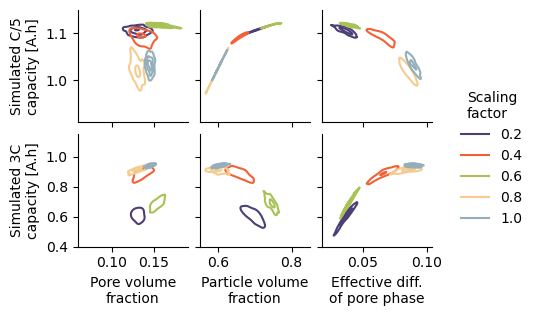

In [20]:
go = sns.pairplot(volume_properties_reduction, 
    hue='reduction', palette=colors_reduction, markers='o', kind='kde',
    y_vars=['qdis_Cb5', 'qdis_3C'],
    x_vars=['vf_pore', 'vf_particle', 'D_eff'],
    height=1.5, plot_kws={'levels':5})
go.y_vars = ['Simulated C/5\ncapacity [A.h]', 'Simulated 3C\ncapacity [A.h]']
go.x_vars = ['Pore volume\nfraction', 'Particle volume\nfraction', 'Effective diff.\nof pore phase']
go._add_axis_labels()
go._legend.set_title('Scaling\nfactor')
go.axes[0,0].set_xlim((0.06, 0.19))
go.axes[0,1].set_xlim((0.55, 0.85))
go.axes[0,0].set_ylim((0.91, 1.15))
go.axes[1,0].set_ylim((0.4, 1.15))
go.savefig('figures/reduction_pairplot.tif', dpi=600)